### Linear Regression Model

We will proceed initially to use the last 3 years to model the data with a simple linear regression.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from collections import defaultdict
import re

In [63]:
year_from = 2005

def load_data(year_from):  
    assert isinstance(year_from,int)
    # Imports
    train = pd.read_csv('data/TrainingSet.csv',index_col=0)
    submission = pd.read_csv('data/SubmissionRows.csv',index_col=0)
    # Remove [YR****] and input '_' for last 3 cols
    train.columns = list(map(lambda x: re.findall(r'\d+',x)[0],train.columns[:36])) + list(map(lambda x: '_'.join(x.split()),train.columns[36:]))
    # Use last 3 years for predictions: This is subjected to change
    train = train.loc[:,f'{year_from}':]
    return train, submission

In [64]:
# Load data:
train, submission = load_data(2005)

In [65]:
def submission_data_missing(train,submission):    
    mask  = train.loc[submission.index,].T.isna().sum()>0
    train_X = train.loc[submission.index,]
    return train_X.loc[mask]

In [66]:
train.loc[submission.index,].T.isna().sum()

559       0
618       0
753       0
1030      0
1896      0
         ..
284474    0
285340    0
285399    0
285534    0
285811    0
Length: 737, dtype: int64

In [67]:
# 16 rows with missing values: Interpolate these values
submission_data_missing(train,submission)

,2005,2006,2007,Country_Name,Series_Code,Series_Name
8038,NaN,NaN,0.918215,Antigua and Barbuda,2.1,Achieve universal primary education
23347,NaN,0.162000,0.197000,Belarus,8.16,Develop a global partnership for development: ...
42800,NaN,0.982781,0.983149,Cambodia,2.1,Achieve universal primary education
52159,NaN,NaN,0.949294,Chile,2.1,Achieve universal primary education
64882,0.000373,NaN,0.000213,Cuba,5.1,Improve maternal health
80838,NaN,NaN,0.004100,Eritrea,8.16,Develop a global partnership for development: ...
85584,NaN,0.988391,0.996179,Fiji,2.1,Achieve universal primary education
105595,0.014000,NaN,0.045000,Guinea,6.7,Combat malaria and other diseases
107578,NaN,NaN,0.138000,Guyana,8.16,Develop a global partnership for development: ...
146351,NaN,NaN,0.005514,Liberia,8.16,Develop a global partnership for development: ...


In [68]:
def interpolate_data(train,submission):
    train_X = train.loc[submission.index,:]
    # Interpolate: Both directions are bfilled and ffilled respectively
    train_X.loc[:,:'2007'] = train_X.loc[:,:'2007'].interpolate(limit_direction='both',axis=1)
    return train_X

In [69]:
# Data:
data = interpolate_data(train,submission)

# Func to split that dataframe to values [2005,2006,2007] and [country_name,series_code,series_name]
def split_dataframe(data):
    raw_data = data.loc[:,:'2007']
    description = data.loc[:,'Country_Name':]
    return raw_data,description

In [70]:
data.loc[8038]

2005                                       0.918215
2006                                       0.918215
2007                                       0.918215
Country_Name                    Antigua and Barbuda
Series_Code                                     2.1
Series_Name     Achieve universal primary education
Name: 8038, dtype: object

In [71]:
# Split:
raw_data,description = split_dataframe(data)

In [72]:
# Export CSV:
raw_data.to_csv('data/raw_data.csv')
description.to_csv('data/description.csv')

In [73]:
def format_dataframe(raw_data):
    """
    Quick utility function to format dataframe into a X,y format with X = Numbers of years from the start, y = values.
    Example:
    Initial Dataframe being:
    2005   0.4
    2006   0.6
    2007   0.8
    
    The function transforms it into
    X   y
    0   0.4
    1   0.6
    2   0.8
    
    Returns: X,y
    
    Note: If we have 10 different timeseries (features) X.shape = (n_years,n_features) so slicing will be needed to predict
    individually.
    """
    # Extract index from raw data before transforming:
    raw_data_index = list(raw_data.index)
    raw_data.columns = raw_data.columns.astype('int')
    # Transponse to have time as index instead of columns
    raw_data = raw_data.T
    X = np.asarray(raw_data.index - raw_data.index[0]).reshape(-1,1)
    y = raw_data.values
    return X,y,raw_data_index

In [74]:
X,y,raw_data_index = format_dataframe(raw_data)

In [75]:
def linear_regression_poly(X,y,degree,year):
    assert isinstance(X,np.ndarray)
    assert isinstance(y,np.ndarray)
    assert isinstance(degree,int) and degree > 0
    assert year >= 2005
    year_pred = np.array([[year % year_from]])
    pipe = Pipeline([('poly',PolynomialFeatures(degree=degree)),('linear',LinearRegression())])
    n_features = y.shape[1]
    predictions_year = defaultdict(list)
    # Fit:
    for i in range(n_features):
        # slice each series:
        y_i = y[:,i]
        pipe.fit(X,y_i)
        # prediction value for year specified
        y_pred = pipe.predict(year_pred)[0]
        predictions_year[f'{year}[YR{year}]'].append(y_pred)
    
     # To dataframe: with correctly indexed submission values
    df = pd.DataFrame(predictions_year,index=raw_data_index)
    return df
        

In [76]:
# Predictions: Polynomial degree = 1:
_2008 = linear_regression_poly(X,y,1,2008).values
_2012 = linear_regression_poly(X,y,1,2012).values

# Into submission:
submission['2008 [YR2008]'] = _2008
submission['2012 [YR2012]'] = _2012
submission.head()

,2008 [YR2008],2012 [YR2012]
559,0.500000,0.640000
618,0.024196,0.037713
753,0.108367,0.095967
1030,0.001000,0.001000
1896,0.960667,0.958667


In [77]:
# Index mapper for plotting:
index_mapper = {k:index for index,k in enumerate(raw_data_index)}

# Plotting:
def plot_predictions(raw_data,description,pred_2008,pred_2012,n_features):
    pred_2008_values = pred_2008
    pred_2012_values = pred_2012
    pred_concat = np.concatenate([pred_2008_values,pred_2012_values],axis=1)
    random_indicators = np.random.choice(raw_data_index,size=n_features)
    # plot:
    fig,ax = plt.subplots(1,1,figsize=(14,8))
    ax.set_title(f'Values from {year_from} including pred: 2008, 2012')
    for i in random_indicators:
        values = raw_data.T.loc[:,i].values
        ax.plot([str(x) for x in range(year_from,2008)],values,label=f'{description.Country_Name[i]} : {description.Series_Name[i]}',marker='o')
        ax.plot(['2008','2012'],pred_concat[index_mapper[i],:],linestyle='--', label=f'{description.Country_Name[i]} : {description.Series_Name[i]} PRED',marker='o')
        ax.legend()

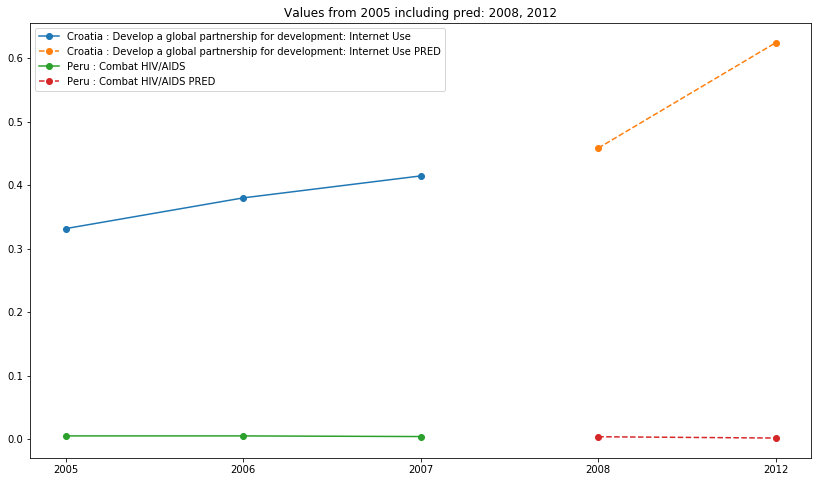

In [79]:
# Plot:
np.random.seed(2)
plot_predictions(raw_data,description,_2008,_2012,2)

In [80]:
# Predictions: Polynomial degree = 2:
_2008 = linear_regression_poly(X,y,2,2008).values
_2012 = linear_regression_poly(X,y,2,2012).values

# Into submission:
submission['2008 [YR2008]'] = _2008
submission['2012 [YR2012]'] = _2012
submission.head()

,2008 [YR2008],2012 [YR2012]
559,0.500000,0.640000
618,0.006028,-0.154871
753,0.108700,0.099500
1030,0.001000,0.001000
1896,0.959000,0.941000


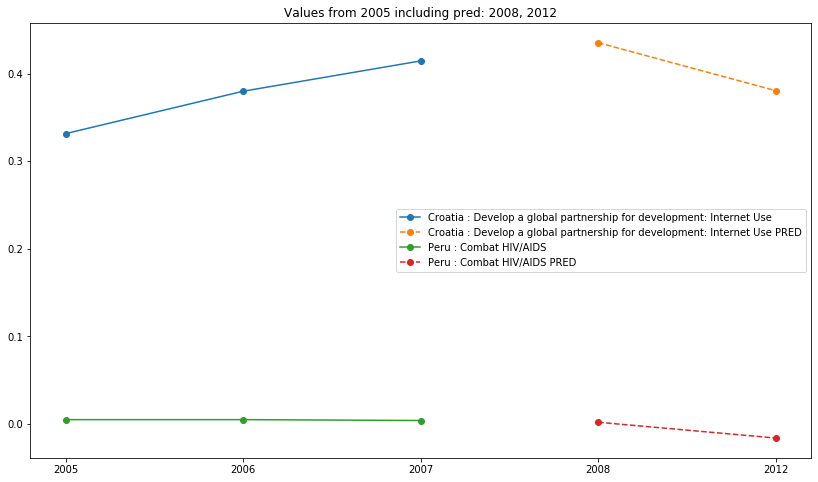

In [81]:
# Plot: degree = 2
np.random.seed(2)
plot_predictions(raw_data,description,_2008,_2012,2)

### Note:

Values from linear regression with degree = 1 scored higher (RMSE = 0.0549). Degree = 2 scored RMSE = 0.2483.

### Ridge Regression:

Adding regularization to possibly dampen the effects of a polynomial of degree 2.

In [82]:
def ridge_regression_poly(X,y,degree,year,alpha):
    assert isinstance(X,np.ndarray)
    assert isinstance(y,np.ndarray)
    assert isinstance(degree,int) and degree > 0
    assert year >= 2005
    year_pred = np.array([[year % year_from]])
    pipe = Pipeline([('poly',PolynomialFeatures(degree=degree)),('linear',Ridge(alpha=alpha))])
    n_features = y.shape[1]
    predictions_year = defaultdict(list)
    # Fit:
    for i in range(n_features):
        # slice each series:
        y_i = y[:,i]
        pipe.fit(X,y_i)
        # prediction value for year specified
        y_pred = pipe.predict(year_pred)[0]
        predictions_year[f'{year}[YR{year}]'].append(y_pred)
    
     # To dataframe: with correctly indexed submission values
    df = pd.DataFrame(predictions_year,index=raw_data_index)
    return df

In [93]:
# Predictions:
_2008_ridge = ridge_regression_poly(X,y,2,2008,8)
_2012_ridge = ridge_regression_poly(X,y,2,2012,35)

# Into submission:
submission['2008 [YR2008]'] = _2008_ridge
submission['2012 [YR2012]'] = _2012_ridge
submission.head()

,2008 [YR2008],2012 [YR2012]
559,0.492566,0.584353
618,0.021903,0.028417
753,0.109054,0.100967
1030,0.001000,0.001000
1896,0.960628,0.959102


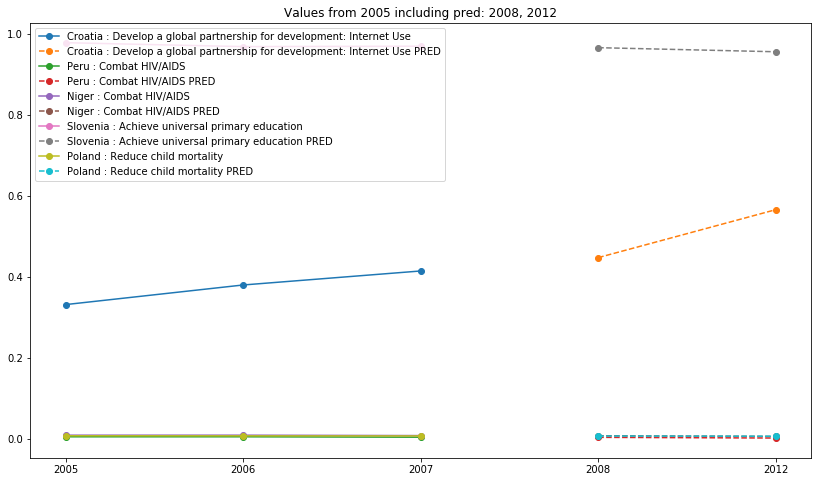

In [84]:
# Plot: degree = 2, Ridge, alpha=30 (Strongly regularized)
np.random.seed(2)
plot_predictions(raw_data,description,_2008_ridge,_2012_ridge,5)

In [94]:
# To CSV:
submission.to_csv('data/ridge_poly2_alpha32.csv')